# 0.0. Imports

In [ ]:
import inflection

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt



from config                  import config
from sqlalchemy              import create_engine

from sklearn.preprocessing   import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC

from scikitplot.metrics      import plot_cumulative_gain 

In [ ]:
pallete  = sns.color_palette(sns.diverging_palette(250, 10, s=75, l=45, n=9))
pallete2 = sns.color_palette(sns.diverging_palette(45, 200, s=75, l=45, n=9)) 

%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 8]

sns.set_palette( pallete )
sns.set_style('darkgrid')

# 0.1. Help Functions 

In [ ]:
def numeric_statistics( df ):
    dic = {
        "type": df.dtypes.values,
        "Unique_Values": df.nunique().values,
        "Mean": df.mean(),
        "Median": df.median(),
        "Std": df.std(),
        "Min": df.min(),
        "Max": df.max(),
        "Range": df.max() - df.min(),
        "Skew": df.skew(),
        "Kurtosis": df.kurtosis()
    }
    
    return pd.DataFrame( dic, index=df.columns )

# 0.2. Loading Data

In [ ]:
df_raw = pd.read_csv( 'data/train.csv' )

# 1.0. Data Description

In [ ]:
df1 = df_raw.copy()

In [ ]:
# rename columns
old_columns = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore( x )
new_columns = list( map( snakecase, old_columns ) )

df1.columns = new_columns

## 1.1. Data Dimension

In [ ]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' )

## 1.2. Data Types

In [ ]:
df1.dtypes

## 1.3. Check NA

In [ ]:
df1.isnull().sum()

## 1.4. Data Descriptive

In [ ]:
num_attributes = df1.select_dtypes( include=['int64','float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64','float64'] )

Descriptive Analysis for each numeric variable. It might be important to take a look at some behavior that a variable might have initially.

1. For instance, I'm able to see the variable 'age' has 66 different values which start from 20 years to 85, and it has its mean and median value close.

2. As seen the target variable has a binary result ( '0' or '1' )

In [ ]:
numeric_statistics( num_attributes )

# 2.0. Feature Engineering

In [ ]:
df2 = df1.copy()

In [ ]:
df2.head()

Rename columns

In [ ]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' 
                                                                        if x == '1-2 Year' else 'below_1_year')
# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# 3.0. Data Filtering

initially, I didn't add any filter here.

In [ ]:
df3 = df2.copy()

# 4.0. EDA

In [ ]:
df4 = df3.copy()

In [ ]:
df4.columns

As seen, in this variable there is an equal distribution of gender 

In [ ]:
# gender
gender_pallete = [pallete[0], pallete[8]]

aux = df4['gender'].value_counts()
plt.pie( aux,  autopct = '%0.0f%%', colors=gender_pallete )
plt.legend( labels=aux.index, fontsize=15, loc='upper left' );

As shown here below, there's a distribution that seems to be really close in their behavior related to the target variable. The age doesn't change too much from each category. But the median of the ages for the category '1' is a little bit higher than the median value from the category '0' 

In [ ]:
# 'age'
age_pallete = [pallete[0], pallete[2]]
sns.boxplot( data= df4, y='age', x='response', palette=age_pallete );

In [ ]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( data=aux00, palette=age_pallete[0]);

In [ ]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( data=aux00, color=age_pallete[1]);

without a filter is hard to catch the behavior of this variable, It's hard to understand how the distribution of the variable actually is. Because there are lots of points shown as an outlier on this boxplot

In [ ]:
# 'annual_premium'
annual_premium_pallete = [pallete2[0], pallete2[8]]

sns.boxplot( data= df4, y='annual_premium', x='response', palette=annual_premium_pallete );

Applying a filter makes this job easier. Now I'm able to see that this variable doesn't bring me lots of information alone. Because its behavior doesn't change from each category from the target variable

In [ ]:
# 'annual_premium'
annual_premium_pallete = [pallete2[0], pallete2[8]]

aux = df4[df4['annual_premium']<80000]
sns.boxplot( data= aux, y='annual_premium', x='response', palette=annual_premium_pallete );

Applying another filter to see how the distribution of the data in this variable behavior alone through these histograms.

In [ ]:
aux = df4[ (df4['annual_premium']<80000) & (df4['annual_premium']>10000)]

aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( data=aux00, color=annual_premium_pallete[0] );

In [ ]:
aux = df4[ (df4['annual_premium']<80000) & (df4['annual_premium']>10000)]

aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( data=aux00, color=annual_premium_pallete[1] );

For this variable "driving license" which is a categorical variable such as the target variable, I decided to make a frequency table to show how much time the occurring happen for this variable related to each categorical value from the target variable. The table is shown in terms of the percentage

The result sounds right or at least makes sense. Because it's expected that, people who already have their license might have a vehicle already and if the people have a vehicle makes sense they already have insurance. But it's not a statement yet, it's just the initial feeling. 

In [ ]:
# driving_license
pd.crosstab( df4['driving_license'], df4['response'], normalize=True )

In this step, the central idea was to identify for each region how many people answered the target variable as 0 or 1. 

As seen in the scatterplot below it's hard to separate the people who marked the response as 1 from the people who marked it as 0. The number of people that answered 1 or 0 is really close.

It might mean that this variable alone doesn't bring a lot of information.

In [ ]:
# region_code
region_pallete = [pallete2[0], pallete2[8]]

aux = df4[['id','region_code','response']].groupby( ['region_code','response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux, palette=region_pallete );

for this variable, I decided to make a frequency table as well to show in terms of percentage the number of people who are already insured or not and who answered 0 or 1.

In [ ]:
# previously_insured on the rows
pd.crosstab( df4['previously_insured'], df4['response'], normalize='index' )

In [ ]:
# previously_insured as a whole
pd.crosstab( df4['previously_insured'], df4['response'], normalize=True )

A frequency table was done to count the occurrence of people who answer the target variable for each vehicle age listed.

As shown, below_1_year and between_1_2_years are the variables that concentrate the most percentage of people who answered and these people answered 0.

In [ ]:
# vehicle_age
df4[['vehicle_age','response']].value_counts( normalize=True ).reset_index().sort_values( 'vehicle_age' )

For this variable, if I don't apply any filter makes the job harder. So, below I'm going to filter the data to visualize it better.

In [ ]:
# policy_sales_channel
aux = df4['policy_sales_channel'].astype( 'object' ).value_counts().reset_index().sort_values( 'index' )
sns.barplot( data=aux, x='index', y='policy_sales_channel' )
plt.xticks( range(0,161,10), rotation=45 );

As seen the policy sales channel with more people as seen in the graph above are:
- 152
- 26
- 124
- 160

In [ ]:
aux_ = df4['policy_sales_channel'].value_counts( normalize=True ).head(4)
aux_

These four channels together represent more than 80% of the people in the dataset. In other words, more than 80% of the people choose one of these channels

In [ ]:
aux_.cumsum()

In [ ]:
# palette definition
palette_aux = pallete[:4]

for i in range(151):
    palette_aux.append( pallete[8] )

# aux dataframe
aux = df4.copy()
aux['policy_sales_channel'] = aux['policy_sales_channel'].astype( 'object' )

df = pd.DataFrame( aux['policy_sales_channel'].value_counts( normalize=True ) ).T 

# legend
legend = aux_.index.to_list()
legend.append( 'Below fourth place' )

df.plot( kind='barh', stacked=True, color=palette_aux )
plt.title( '% Of each different Policy Sales Channel' )
plt.xlabel( '%', fontsize=15 )
plt.xticks( aux_.cumsum() )
plt.legend( legend );

This has a uniform behavior, it might suggest that this variable might not be useful to our prediction model.

In [ ]:
# vintage
vintage_pallete = [pallete2[0], pallete2[8]]

sns.boxplot( data= df4, y='vintage', x='response', palette=vintage_pallete );

In [ ]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( data=aux00, color=vintage_pallete[0] );

In [ ]:
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( data=aux00, color=vintage_pallete[1] );

these variables are very balanced.

In [ ]:
# vehicle_damage
aux = df4['vehicle_damage'].value_counts( normalize=True ).reset_index()
sns.barplot( data=aux, x='index', y='vehicle_damage', palette=gender_pallete );

Applying a filter for each target category(0 or 1) it's possible to see some behavior... when the variable target chosen is 1 there is a clearly unbalanced in this variable.

What I understand was that most people who have had an accident (vehicle damage) are more close to accepting the insurance. That's might suggest that people have knowledge of how bad an accident might be, and then they become more careful.

In [ ]:
aux = df4.loc[ df4['response']==1, 'vehicle_damage'].value_counts( normalize=True ).reset_index()
sns.barplot( data=aux, x='index', y='vehicle_damage', palette=gender_pallete );

In [ ]:
aux = df4.loc[ df4['response']==0, 'vehicle_damage'].value_counts( normalize=True ).reset_index()
sns.barplot( data=aux, x='index', y='vehicle_damage', palette=gender_pallete );

In the target variable is visible that there are clearly unbalanced data here.

In [ ]:
# response
sns.countplot( x='response', data=df4 );

# 5.0. Data Preparation

In [ ]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

X_train, X_validation, y_train, y_validation = train_test_split( X, y, test_size=0.2 )

df5 = pd.concat( [X_train, y_train], axis=1 ).reset_index( drop=True )

In [ ]:
df5.columns

## Standardization

In [ ]:
ss = StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## Rescaling

In [ ]:
mms_age     = MinMaxScaler()
mms_vintage = MinMaxScaler()
# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

## Encoder

In [ ]:
# gender
target_encoding_gender = df5.groupby( 'gender' )['response'].mean()
df5['gender'] = df5['gender'].map( target_encoding_gender )

# region_code -  Target encoding
target_encoding_region_code = df5.groupby( 'region_code' )['response'].mean()
df5['region_code'] = df5['region_code'].map( target_encoding_region_code )
                               
# vehicle_age - One Hot Encoding 
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - frequency enconding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

## Validation preparation

In [ ]:
# annual_premium
X_validation['annual_premium'] = ss.transform( X_validation[['annual_premium']].values )

# age
X_validation['age'] = mms_age.transform( X_validation[['age']].values )

# vintage
X_validation['vintage'] = mms_vintage.transform( X_validation[['vintage']].values )

# gender
X_validation['gender'] = X_validation['gender'].map( target_encoding_gender )

# region_code
X_validation['region_code'] = X_validation['region_code'].map( target_encoding_region_code )

# vehicle_age
X_validation = pd.get_dummies( X_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel
X_validation['policy_sales_channel'] = X_validation['policy_sales_channel'].map( fe_policy_sales_channel )

X_validation.fillna( 0, inplace=True )

# 6.0. Feature Selection

## Features Importancia

In [ ]:
# Model definition
forest = ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
X_train_n = df5.drop( ['id','response'], axis=1 )
y_train_n = y_train.values
forest.fit( X_train_n, y_train_n )

In [ ]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=1 )
indices = np.argsort( importances )[::-1]

# print the feature ranking
print( "Feature Ranking" )
df = pd.DataFrame()

for i,j in zip( X_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df,aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title( 'Feature Importances' )
plt.bar( range(X_train_n.shape[1]), importances[indices], color=pallete[8], yerr=std[indices], align='center' )
plt.xticks( range(X_train_n.shape[1]), indices )
plt.xlim([-1,X_train_n.shape[1]])
plt.show()

In [ ]:
cols_selected = ['vintage', 'annual_premium','age', 'region_code',  'vehicle_damage','previously_insured',
                 'policy_sales_channel']  

X_train = df5[cols_selected]
X_val = X_validation[cols_selected].copy()

y_val = y_validation

# 7.0. Machine Learning

## 7.1. KNN

In [ ]:
# model definition
knn = KNeighborsClassifier( n_neighbors=5 )

# model trainijng
knn.fit( X_train, y_train )

# model prediction - poder de genaralização
yhat_knn = knn.predict_proba( X_val )

paletteaux = [pallete[0], pallete[8]]
sns.set_palette( paletteaux )

# Acumalitve gain
plot_cumulative_gain( y_val, yhat_knn );

## 7.2. Logistic Regression

In [ ]:
# model definition
lg = LogisticRegression( random_state=42 )

# model training
lg.fit( X_train, y_train )

# predict
yhat_lg = lg.predict_proba( X_val )

# Acumalitve gain
plot_cumulative_gain( y_val, yhat_lg );

## 7.3. Random Forest

In [ ]:
# model definition
rf = RandomForestClassifier( n_estimators=250, random_state=42, n_jobs=-1 )

# model training
rf.fit( X_train, y_train )

# predict
yhat_rf = rf.predict_proba( X_val )

# Acumalitve gain
plot_cumulative_gain( y_val, yhat_rf );

## 7.4. Extra Trees

In [ ]:
# model definition
ext = ExtraTreesClassifier( n_estimators=250, random_state=42, n_jobs=-1 )

# model training
ext.fit( X_train, y_train )

# predict
yhat_ext = ext.predict_proba( X_val )

# Acumalitve gain
plot_cumulative_gain( y_val, yhat_ext );

# 8.0. Model Performace

In [96]:
def precision_at_k( data, k=2000 ):
    
    data = data.reset_index( drop=True )
    
    # ranking
    data['k'] = data.index + 1

    # cols selected
    data = data[['k','id','response','score']]

    #accumulated sum
    data['cumsum'] = data['response'].cumsum()

    # precision top k
    data['precision_at_k'] = data['cumsum'] / data['k']
    
    return data.loc[k,'precision_at_k']

In [97]:
def recall_at_k( data, k=2000 ):
    
    data = data.reset_index( drop=True )
    
    # ranking
    data['k'] = data.index + 1

    # cols selected
    data = data[['k','id','response','score']]

    #accumulated sum
    data['cumsum'] = data['response'].cumsum()

    # precision top k
    data['recall_at_k'] = data['cumsum'] / data['response'].sum()
    
    return data.loc[k,'recall_at_k']

In [98]:
df8 = X_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_knn[:,1].tolist()

# sorte client by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# print precision at k
precision_at_50 = precision_at_k( df8, k=50 )
print(f' Precision at K: {precision_at_50}' )

# print recall at k
recall_at_50 = recall_at_k( df8, k=50 )
print(f' Recall at K: {recall_at_50}' )

 Precision at K: 0.35294117647058826
 Recall at K: 0.00194321494116377


In [102]:
df8 = X_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_knn[:,1].tolist()

# sorte client by propensity score
df8 = df8.sort_values( 'score', ascending=False )
df8 = df8.reset_index( drop=True )
    
# ranking
df8['k'] = df8.index + 1

# cols selected
df8 = df8[['k','id','response','score']]

#accumulated sum
df8['cumsum'] = df8['response'].cumsum()

# precision top k
df8['precision_at_k'] = df8['cumsum'] / df8['k']

# recall top k
df8['recall_at_k'] = df8['cumsum'] / df8['response'].sum()

df8.head()

,k,id,response,score,cumsum,precision_at_k,recall_at_k
0,1,202460,0,1.0,0,0.0,0.000000
1,2,8979,0,1.0,0,0.0,0.000000
2,3,192875,0,1.0,0,0.0,0.000000
3,4,125217,0,1.0,0,0.0,0.000000
4,5,132155,1,1.0,1,0.2,0.000108


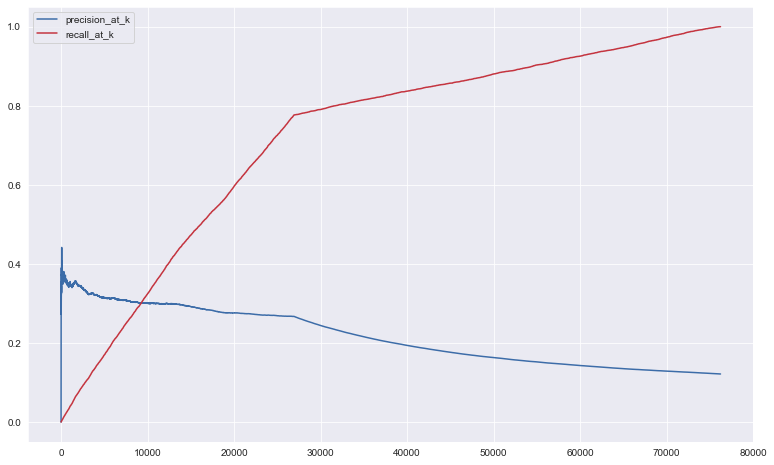

In [105]:
df8[['precision_at_k','recall_at_k']].plot();